In [1]:
import pandas as pd
import numpy as np

In [2]:
fx = pd.read_csv(
    'data/EURUSD_1min.txt',
    names = ['day', 'time', 'open',
            'high', 'low', 'close', 'volume'])

fx['datetime'] = fx['day'].astype(str) + " " + fx['time']
fx['datetime'] = pd.to_datetime(fx['datetime'], infer_datetime_format = True)

fx = fx.drop(columns = ['day', 'time'])

# Preprocessing

- Step 1: linearly interpolate gaps (shoot, not sure how to do this in parallel besides filling in all gaps and then getting rid of friday -> sunday
- Step 2: so we will go from 21:00 to 21:00 from sunday to friday
    - make a "trading day" feature starting from 21:00 of 
    - get rid of stragler days with no trades at end and beginning if the don't match up right
- Step 3: subtract the day's open at 21:00 from each day (group by day easy) -- let's not honestly...
- Step 4: make relative volume indicator using comparing real volume to groupby day's MA -- yeah I mean for now let's not
- Step 5: 60min HLC

- Step 6: create train, validation and test datasets
- Step 7: divide each column by their std (ungrouped) USING ONLY TRAINING SET MAKING SURE TO SAVE THIS NUMBER -- not for now


Make JSON:
- make the weekday and relative volume a feature
- make inputs_embeds a 2d array containing OHLCV and label 2D array of HLC (no day of week)
- store as JSON

In [3]:
# Linearly interpolate time gaps
fx = fx.set_index('datetime').asfreq('1min')
fx['close'] = fx['close'].fillna(method = 'ffill')
fx['volume'] = fx['volume'].fillna(0) # no volume in gaps (according to first rate data people)

# fill open high and low with most recent close
fx = fx.fillna({
    'open': fx['close'],
    'high': fx['close'],
    'low': fx['close']
})

In [4]:
# define the "trading day" as from starting on 9pm UTC of the previous day ending at 8:59pm UTC
fx['day'] = fx.index.dayofweek 
fx.loc[fx.between_time('21:00', '23:59').index, 'day'] += 1
fx['day'] = fx['day'] % 7 # sunday = 6, then + 1 would be 7 but we want that roll over to monday = 0

# ordinal trading day since start of data (just for help in preprocessing)
fx['ordinal_day'] = (fx['day'] != fx['day'].shift()).cumsum()

<AxesSubplot:>

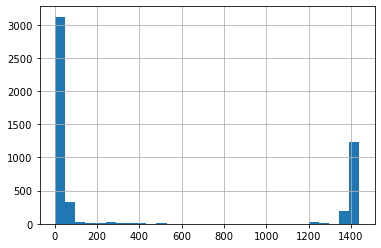

In [5]:
# look at distribution of how many 0 volume minute
(fx['volume'] == 0.).groupby(fx['ordinal_day']).sum().hist(bins = 30)

In [6]:
# let's just arbitrary say there should be less than 100 zero volume -- shouldn't really mattter in the end
voluminous_index = (fx['volume'] == 0.).groupby(fx['ordinal_day']).filter(lambda x: x.sum() < 100).index
fx = fx.loc[voluminous_index]

In [7]:
# quick sanity check of data 
fx.between_time('20:59', '21:01').tail(15)

,open,high,low,close,volume,day,ordinal_day
datetime,,,,,,,
2022-09-26 20:59:00,0.96080,0.96093,0.96060,0.96081,50.0,0,5016
2022-09-26 21:00:00,0.96073,0.96090,0.96060,0.96078,26.0,1,5017
2022-09-26 21:01:00,0.96087,0.96090,0.96073,0.96081,15.0,1,5017
2022-09-27 20:59:00,0.95943,0.95946,0.95910,0.95930,54.0,1,5017
2022-09-27 21:00:00,0.95930,0.95940,0.95908,0.95908,20.0,2,5018
2022-09-27 21:01:00,0.95914,0.95920,0.95870,0.95890,10.0,2,5018
2022-09-28 20:59:00,0.97372,0.97388,0.97283,0.97283,138.0,2,5018
2022-09-28 21:00:00,0.97283,0.97358,0.97283,0.97313,13.0,3,5019
2022-09-28 21:01:00,0.97340,0.97350,0.97290,0.97330,9.0,3,5019


In [8]:
# # moving average to compare volume to (arbitrarily set to 3 hours) (shouldn't affect performance much)
# fx.groupby('ordinal_day').rolling(5000, min_periods = 0)['volume'].mean().reset_index(drop = True, level = 0)

# # relative volume 
# fx["relative_volume"] = fx['volume'] / fx.rolling(500)

In [9]:
# 60 min HLC (compare to 30min or 120min, short time periods are likely to have less std and more data though harder to capitalize on)
period = 120

fx['future_high'] = fx['close'].rolling(period).max().shift(-period)
fx['future_low'] = fx['close'].rolling(period).min().shift(-period)
fx['future_close'] = fx['close'].shift(-period)

In [10]:
# get rid of first and last day due to data incompleteness
fx = fx.drop(fx[fx['ordinal_day'] == fx['ordinal_day'].min()].index)
fx = fx.drop(fx[fx['ordinal_day'] == fx['ordinal_day'].max()].index)

## de-meaning using day's opening price

In [11]:
price_cols = ['open', 'high', 'low', 'close', 'future_high', 'future_low', 'future_close']
fx[price_cols] = fx[price_cols].sub(fx.groupby('ordinal_day')['close'].transform('first'), axis = 0)

In [12]:
fx

,open,high,low,close,volume,day,ordinal_day,future_high,future_low,future_close
datetime,,,,,,,,,,
2009-01-04 21:00:00,0.00000,0.00000,0.00000,0.00000,3.0,0,4,0.00060,-0.00210,-0.00130
2009-01-04 21:01:00,0.00000,0.00000,-0.00050,-0.00020,8.0,0,4,0.00060,-0.00210,-0.00110
2009-01-04 21:02:00,-0.00020,-0.00020,-0.00020,-0.00020,2.0,0,4,0.00060,-0.00210,-0.00100
2009-01-04 21:03:00,-0.00040,-0.00040,-0.00040,-0.00040,4.0,0,4,0.00060,-0.00210,-0.00080
2009-01-04 21:04:00,-0.00060,-0.00050,-0.00080,-0.00080,6.0,0,4,0.00060,-0.00210,0.00010
...,...,...,...,...,...,...,...,...,...,...
2022-09-30 20:55:00,-0.00168,-0.00159,-0.00190,-0.00180,77.0,4,5020,-0.00084,-0.00374,-0.00153
2022-09-30 20:56:00,-0.00169,-0.00131,-0.00190,-0.00163,112.0,4,5020,-0.00084,-0.00374,-0.00146
2022-09-30 20:57:00,-0.00166,-0.00147,-0.00206,-0.00180,42.0,4,5020,-0.00084,-0.00374,-0.00154


In [13]:
fx.to_parquet("data/EURUSD60.pq", index = False)

# grouping by days

In [14]:
fx['ohlcv'] = fx[['open', 'high', 'low', 'close', 'volume']].values.tolist()
fx_ohlcv = fx.groupby('ordinal_day')['ohlcv'].agg(lambda x: list(x))

In [15]:
fx['future_hlc'] = fx[['future_high', 'future_low', 'future_close']].values.tolist()
fx_future = fx.groupby('ordinal_day')['future_hlc'].agg(lambda x: list(x))

In [16]:
fx_ohlcv

ordinal_day
4       [[0.0, 0.0, 0.0, 0.0, 3.0], [0.0, 0.0, -0.0004...
5       [[-0.00029999999999996696, 0.0, -0.00049999999...
6       [[0.000300000000000189, 0.000500000000000167, ...
7       [[-0.0006999999999999229, 0.000199999999999977...
8       [[-0.0006999999999999229, 0.000199999999999977...
                              ...                        
5016    [[-0.00029999999999996696, 0.0, -0.00029999999...
5017    [[-4.999999999999449e-05, 0.000120000000000008...
5018    [[0.00021999999999999797, 0.000319999999999986...
5019    [[-0.000300000000000078, 0.0004499999999999504...
5020    [[-0.000300000000000078, 0.0001999999999999779...
Name: ohlcv, Length: 3443, dtype: object

In [17]:
fx_future

ordinal_day
4       [[0.000600000000000156, -0.0020999999999999908...
5       [[0.006099999999999994, -0.0003999999999999559...
6       [[0.0018000000000000238, -0.002199999999999979...
7       [[0.0030000000000001137, -0.000599999999999933...
8       [[-0.00029999999999996696, -0.0044999999999999...
                              ...                        
5016    [[0.0038399999999999546, -9.00000000000345e-05...
5017    [[0.00048000000000003595, -0.00229000000000001...
5018    [[0.0008199999999999319, -0.000780000000000002...
5019    [[0.0006699999999999484, -0.001290000000000013...
5020    [[0.00270999999999999, -0.0008900000000000574,...
Name: future_hlc, Length: 3443, dtype: object

In [18]:
pd.DataFrame({"ohlcv": fx_ohlcv, "future": fx_future}).to_parquet('data/EURUSD_day.pq', index = False)

In [49]:
foo = """"sharpe -0.0015, sharpe loss 1.01
sharpe -0.00024, sharpe loss 1.0
sharpe 0.00034, sharpe loss 0.998
sharpe -0.00059, sharpe loss 1.0
sharpe 0.00062, sharpe loss 0.996
sharpe -0.0012, sharpe loss 1.01
sharpe -0.00044, sharpe loss 1.0
sharpe -0.00094, sharpe loss 1.01
sharpe 0.00031, sharpe loss 0.998
sharpe -0.0025, sharpe loss 1.02
sharpe -0.00088, sharpe loss 1.01
sharpe -0.00033, sharpe loss 1.0
sharpe 0.00052, sharpe loss 0.997
sharpe -0.00014, sharpe loss 1.0
sharpe 0.00061, sharpe loss 0.996
sharpe -0.00088, sharpe loss 1.01
sharpe -0.00054, sharpe loss 1.0
sharpe 3.4e-06, sharpe loss 1.0
sharpe -0.0011, sharpe loss 1.01
sharpe 0.00035, sharpe loss 0.998
sharpe -0.00075, sharpe loss 1.01
sharpe 0.0011, sharpe loss 0.993
sharpe -0.0007, sharpe loss 1.01
sharpe -0.0005, sharpe loss 1.0
sharpe -0.0011, sharpe loss 1.01
sharpe 0.00068, sharpe loss 0.996
sharpe -0.00027, sharpe loss 1.0
sharpe -0.00041, sharpe loss 1.0
sharpe -0.00077, sharpe loss 1.01
sharpe 0.0014, sharpe loss 0.991
sharpe 0.00087, sharpe loss 0.994
sharpe 0.0016, sharpe loss 0.989
sharpe -0.0011, sharpe loss 1.01
sharpe 0.001, sharpe loss 0.993
sharpe 3.8e-06, sharpe loss 1.0
sharpe 0.0015, sharpe loss 0.989
sharpe 0.00012, sharpe loss 0.999
sharpe -0.001, sharpe loss 1.01
sharpe 0.00043, sharpe loss 0.997
sharpe -0.0012, sharpe loss 1.01
sharpe -1.8e-05, sharpe loss 1.0
sharpe 0.00055, sharpe loss 0.996
sharpe -0.00045, sharpe loss 1.0
sharpe 0.0011, sharpe loss 0.993
sharpe -0.00023, sharpe loss 1.0
sharpe -0.00015, sharpe loss 1.0
sharpe 0.0014, sharpe loss 0.991
sharpe 0.00039, sharpe loss 0.998
sharpe 0.00016, sharpe loss 0.999
sharpe 0.0014, sharpe loss 0.99
sharpe -0.0015, sharpe loss 1.01
sharpe -0.0016, sharpe loss 1.01
sharpe -1.1e-05, sharpe loss 1.0
sharpe -0.00026, sharpe loss 1.0
sharpe 0.00024, sharpe loss 0.999
sharpe -0.00018, sharpe loss 1.0
sharpe 0.00047, sharpe loss 0.997
sharpe 0.0013, sharpe loss 0.991
sharpe -0.001, sharpe loss 1.01
sharpe -0.00054, sharpe loss 1.0
sharpe -0.00084, sharpe loss 1.01
sharpe 0.00016, sharpe loss 0.999
sharpe -0.00038, sharpe loss 1.0
sharpe -0.00018, sharpe loss 1.0
sharpe 0.0022, sharpe loss 0.986
sharpe -0.00041, sharpe loss 1.0
sharpe 0.0005, sharpe loss 0.997
sharpe 0.0019, sharpe loss 0.988
sharpe 0.0011, sharpe loss 0.992
sharpe 0.0015, sharpe loss 0.99
sharpe -0.0011, sharpe loss 1.01
sharpe -0.00058, sharpe loss 1.0
sharpe -0.0012, sharpe loss 1.01
sharpe 0.0012, sharpe loss 0.992
sharpe 0.00052, sharpe loss 0.997
sharpe -0.0016, sharpe loss 1.01
sharpe 0.0013, sharpe loss 0.991
sharpe 0.00074, sharpe loss 0.995
sharpe -0.0012, sharpe loss 1.01
sharpe 0.0017, sharpe loss 0.988
sharpe 0.00078, sharpe loss 0.995
sharpe 0.00088, sharpe loss 0.994
sharpe -0.00043, sharpe loss 1.0
sharpe 0.0015, sharpe loss 0.99
sharpe -0.0002, sharpe loss 1.0
sharpe -0.0011, sharpe loss 1.01
sharpe 0.00039, sharpe loss 0.997
sharpe -0.0011, sharpe loss 1.01
sharpe -0.0012, sharpe loss 1.01
sharpe 6.1e-05, sharpe loss 1.0
sharpe -0.00094, sharpe loss 1.01
sharpe 0.00037, sharpe loss 0.998
sharpe -0.00031, sharpe loss 1.0
sharpe -0.00076, sharpe loss 1.01
sharpe -0.00065, sharpe loss 1.0
sharpe 0.00026, sharpe loss 0.998
sharpe -8.8e-05, sharpe loss 1.0
sharpe -0.0013, sharpe loss 1.01
sharpe 5.8e-05, sharpe loss 1.0
sharpe -1.5e-06, sharpe loss 1.0
sharpe 0.00038, sharpe loss 0.998
sharpe -0.0016, sharpe loss 1.01
sharpe 0.00016, sharpe loss 0.999
sharpe -8.6e-05, sharpe loss 1.0
sharpe -0.00076, sharpe loss 1.01
sharpe 0.0001, sharpe loss 0.999
sharpe 0.0019, sharpe loss 0.987
sharpe -0.00073, sharpe loss 1.01
sharpe 0.001, sharpe loss 0.993
sharpe 0.00014, sharpe loss 0.999
sharpe -0.0012, sharpe loss 1.01
sharpe -0.0023, sharpe loss 1.02
sharpe 0.00068, sharpe loss 0.995
sharpe -0.00031, sharpe loss 1.0
sharpe 0.0015, sharpe loss 0.99
sharpe -0.00016, sharpe loss 1.0
sharpe -0.0013, sharpe loss 1.01
sharpe -0.0016, sharpe loss 1.01
sharpe 0.001, sharpe loss 0.993
sharpe -0.0011, sharpe loss 1.01
sharpe 0.00026, sharpe loss 0.999
sharpe -0.00071, sharpe loss 1.01
sharpe 0.0012, sharpe loss 0.992
sharpe -7.8e-06, sharpe loss 1.0
sharpe -3.8e-06, sharpe loss 1.0
sharpe -0.00067, sharpe loss 1.0
sharpe 0.00029, sharpe loss 0.998
sharpe 5.6e-05, sharpe loss 1.0
sharpe 0.0017, sharpe loss 0.988
sharpe -0.00073, sharpe loss 1.01
sharpe -0.0006, sharpe loss 1.0
sharpe 0.00037, sharpe loss 0.997
sharpe -1.4e-05, sharpe loss 1.0
sharpe 0.0014, sharpe loss 0.991
sharpe -0.00027, sharpe loss 1.0
sharpe -0.00013, sharpe loss 1.0
sharpe 0.0027, sharpe loss 0.982
sharpe 0.0018, sharpe loss 0.988
sharpe 0.00091, sharpe loss 0.994
sharpe -0.0011, sharpe loss 1.01
sharpe -0.00048, sharpe loss 1.0
sharpe 0.00023, sharpe loss 0.999
sharpe -5.7e-05, sharpe loss 1.0
sharpe 0.00012, sharpe loss 0.999
sharpe 0.00054, sharpe loss 0.996
sharpe 0.00088, sharpe loss 0.994
sharpe 0.00016, sharpe loss 0.999
sharpe -0.0003, sharpe loss 1.0
sharpe -5e-06, sharpe loss 1.0
sharpe 0.00088, sharpe loss 0.994
sharpe 0.00056, sharpe loss 0.996
sharpe -0.0011, sharpe loss 1.01
sharpe 0.00019, sharpe loss 0.999
sharpe 0.00052, sharpe loss 0.997
sharpe 9.8e-05, sharpe loss 0.999
sharpe 0.00019, sharpe loss 0.999
sharpe 0.00035, sharpe loss 0.998
sharpe -0.00028, sharpe loss 1.0
sharpe 0.00047, sharpe loss 0.997
sharpe -0.00063, sharpe loss 1.0
sharpe -0.00031, sharpe loss 1.0
sharpe -0.00055, sharpe loss 1.0
sharpe -0.00091, sharpe loss 1.01
sharpe 0.00048, sharpe loss 0.997
sharpe -0.00018, sharpe loss 1.0
sharpe 0.00018, sharpe loss 0.999
sharpe 0.00054, sharpe loss 0.997
sharpe 7.7e-05, sharpe loss 1.0
sharpe 0.0016, sharpe loss 0.989
sharpe 0.00042, sharpe loss 0.997
sharpe 0.00035, sharpe loss 0.998
sharpe -0.0012, sharpe loss 1.01
sharpe 0.0014, sharpe loss 0.99
sharpe -8.2e-05, sharpe loss 1.0
sharpe 0.0007, sharpe loss 0.995
sharpe -0.00034, sharpe loss 1.0
sharpe -0.0011, sharpe loss 1.01
sharpe -0.00023, sharpe loss 1.0
sharpe -0.00029, sharpe loss 1.0
sharpe 0.00033, sharpe loss 0.998
sharpe -0.00084, sharpe loss 1.01
sharpe -2.9e-05, sharpe loss 1.0
sharpe -0.00026, sharpe loss 1.0
sharpe -0.00063, sharpe loss 1.0
sharpe -0.00071, sharpe loss 1.0
sharpe 0.00062, sharpe loss 0.996
sharpe 0.00054, sharpe loss 0.996
sharpe -0.00014, sharpe loss 1.0
sharpe 0.0003, sharpe loss 0.998
sharpe 0.00013, sharpe loss 0.999
sharpe -0.00027, sharpe loss 1.0
sharpe 0.0011, sharpe loss 0.993
sharpe 0.0008, sharpe loss 0.995
sharpe -2.3e-05, sharpe loss 1.0
sharpe 2.8e-05, sharpe loss 1.0
sharpe 0.0007, sharpe loss 0.995
sharpe -0.00098, sharpe loss 1.01
sharpe 0.00042, sharpe loss 0.997
sharpe 0.00048, sharpe loss 0.997
sharpe 0.00026, sharpe loss 0.998
"""

In [50]:
# re.split(" |,|\n", foo)[1::6]

In [53]:
import re
import numpy as np
np.array(re.split(" |,|\n", foo)[1::6]).astype(float).mean() / np.array(re.split(" |,|\n", foo)[1::6]).astype(float).std()

0.010733672686040984